In [210]:
import pandas as pd
import urllib2
import json
from pandas.io.json import json_normalize
from get_jsonparsed_data import get_jsonparsed_data 
import os
import scipy.stats as stats
import numpy as np
import pylab as pl
import statsmodels.formula.api as smf

%pylab inline

#Connect to file where API key is stored.
#json_data = open("apidef.json").read()
#myAPI = json.loads(json_data)

Populating the interactive namespace from numpy and matplotlib


In [211]:
PUIDATA=os.getenv('PUIDATA')
import sys
sys.path.insert(0, PUIDATA)
from getCitiBikeCSV import getCitiBikeCSV
datestring = '201508'
getCitiBikeCSV(datestring)

('Downloading', '201508')
file in place, you can continue


In [212]:
df_aug = pd.read_csv(os.getenv('PUIDATA')+'/' + datestring + '-citibike-tripdata.csv')
df_aug.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,1202,8/1/2015 00:00:04,8/1/2015 00:20:07,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,23253,Subscriber,1987.0,1
1,301,8/1/2015 00:00:05,8/1/2015 00:05:06,450,W 49 St & 8 Ave,40.762272,-73.987882,479,9 Ave & W 45 St,40.760193,-73.991255,22675,Subscriber,1951.0,2
2,431,8/1/2015 00:00:06,8/1/2015 00:07:18,312,Allen St & E Houston St,40.722055,-73.989111,296,Division St & Bowery,40.714131,-73.997047,19831,Subscriber,1985.0,1
3,273,8/1/2015 00:00:09,8/1/2015 00:04:43,382,University Pl & E 14 St,40.734927,-73.992005,229,Great Jones St,40.727434,-73.993790,22765,Subscriber,1975.0,1
4,1256,8/1/2015 00:00:17,8/1/2015 00:21:13,352,W 56 St & 6 Ave,40.763406,-73.977225,432,E 7 St & Avenue A,40.726218,-73.983799,22127,Subscriber,1978.0,1


In [213]:
df_aug['age']=int(datestring[:4])-df_aug['birth year']
df_aug.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender', u'age'],
      dtype='object')

In [214]:
df_aug=df_aug[(df_aug['usertype']=="Subscriber")] 
df_aug.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,age
0,1202,8/1/2015 00:00:04,8/1/2015 00:20:07,168,W 18 St & 6 Ave,40.739713,-73.994564,385,E 55 St & 2 Ave,40.757973,-73.966033,23253,Subscriber,1987.0,1,28.0
1,301,8/1/2015 00:00:05,8/1/2015 00:05:06,450,W 49 St & 8 Ave,40.762272,-73.987882,479,9 Ave & W 45 St,40.760193,-73.991255,22675,Subscriber,1951.0,2,64.0
2,431,8/1/2015 00:00:06,8/1/2015 00:07:18,312,Allen St & E Houston St,40.722055,-73.989111,296,Division St & Bowery,40.714131,-73.997047,19831,Subscriber,1985.0,1,30.0
3,273,8/1/2015 00:00:09,8/1/2015 00:04:43,382,University Pl & E 14 St,40.734927,-73.992005,229,Great Jones St,40.727434,-73.993790,22765,Subscriber,1975.0,1,40.0
4,1256,8/1/2015 00:00:17,8/1/2015 00:21:13,352,W 56 St & 6 Ave,40.763406,-73.977225,432,E 7 St & Avenue A,40.726218,-73.983799,22127,Subscriber,1978.0,1,37.0


In [215]:
df_aug=df_aug[['tripduration', 'age']]
minutecalc = lambda x: round(x/60, 1)
df_aug['tripduration']=df_aug['tripduration'].apply(minutecalc)
df_aug.head()

,tripduration,age
0,20.0,28.0
1,5.0,64.0
2,7.0,30.0
3,4.0,40.0
4,20.0,37.0


In [216]:
df_aug=df_aug[df_aug['age']<80] #Limiting the data set to only riders under 75.
#filt= ((df_aug.tripduration > 45))
#df_aug=df_aug[filt]
#df_aug=df_aug[df_aug['tripduration']<180] 
df_aug.head()

,tripduration,age
0,20.0,28.0
1,5.0,64.0
2,7.0,30.0
3,4.0,40.0
4,20.0,37.0


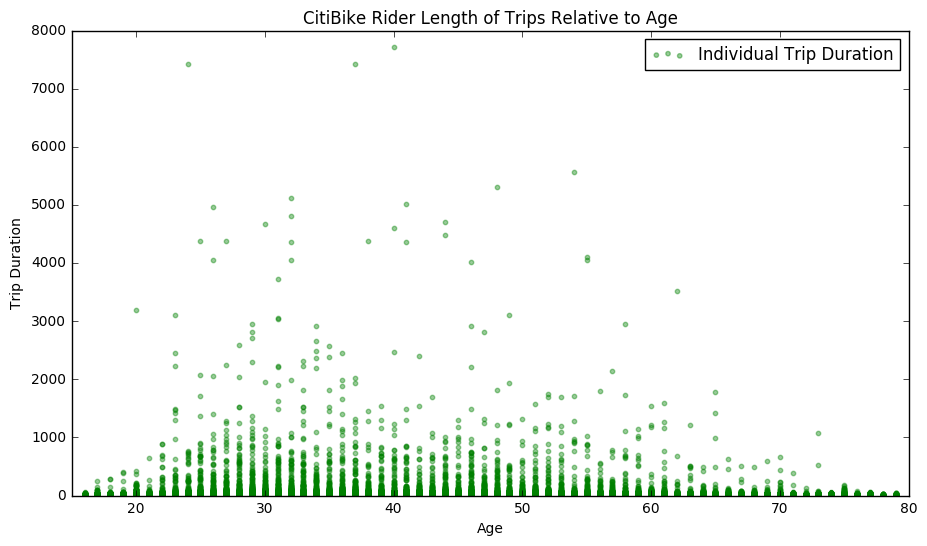

In [237]:
# plot lstat (% lower status of the population) against median value
pl.figure(figsize=(6 * 1.8, 6))
pl.scatter(df_aug.age, df_aug.tripduration, s=10, alpha=0.4, color="green", label="Individual Trip Duration")
pl.xlabel('Age')
pl.ylabel('Trip Duration')
#pl.text(0, -20,'lower status of the population) against median value')
pl.ylim(0,8000)
pl.xlim(15,80)
pl.title("CitiBike Rider Length of Trips Relative to Age")
# points linearlyd space on lstats from minimum to maximom, 100 points
x = pd.DataFrame({'age': np.linspace(df_aug.age.min(), df_aug.age.max(), 25)})
#linspace creates an array of a given number of elements evenly spaced between a minimum of maximum. 

plt.legend()

<center><b>Figure 1:</b> Plot shows length of CitiBike ride, relative to rider's age.</center>